In [4]:
import sys
sys.path.insert(0, '../') 
import datastructure
import sphereGIS 
import geopandas
import numpy
import pyhdf.SD
import math
import shapely
import matplotlib.pyplot as plt

In [5]:
# Load the polygon
polygons = geopandas.read_file('data/santa_barbara.gpkg') 

geom = polygons.iloc[0].geometry[0]
polygon = datastructure.SphericalPolygon(geom)

In [6]:
polygon.get_convex()

In [15]:
# Loading granule
fname = 'data/MOD09.A2020032.1940.006.2020034015024.hdf'
hdf = pyhdf.SD.SD(fname)
lat = hdf.select('Latitude').get().flatten()
lon = hdf.select('Longitude').get().flatten()

x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

points = numpy.array([x, y, z]).transpose()

In [16]:
# Getting Candidates
dots = numpy.einsum('ji,mi->jm', points, polygon.convex_edges.gcs)
n_constraints = len(polygon.convex_edges.gcs)
inside_convex = numpy.where(numpy.sum(dots>0, axis=1)==n_constraints)[0]
candidate_points = points[inside_convex]

In [17]:
points = []
for j_i in inside_convex:
    points.append(shapely.geometry.Point(lon[j_i], lat[j_i]))
convex_points = geopandas.GeoDataFrame({'geom': points}).set_geometry('geom')

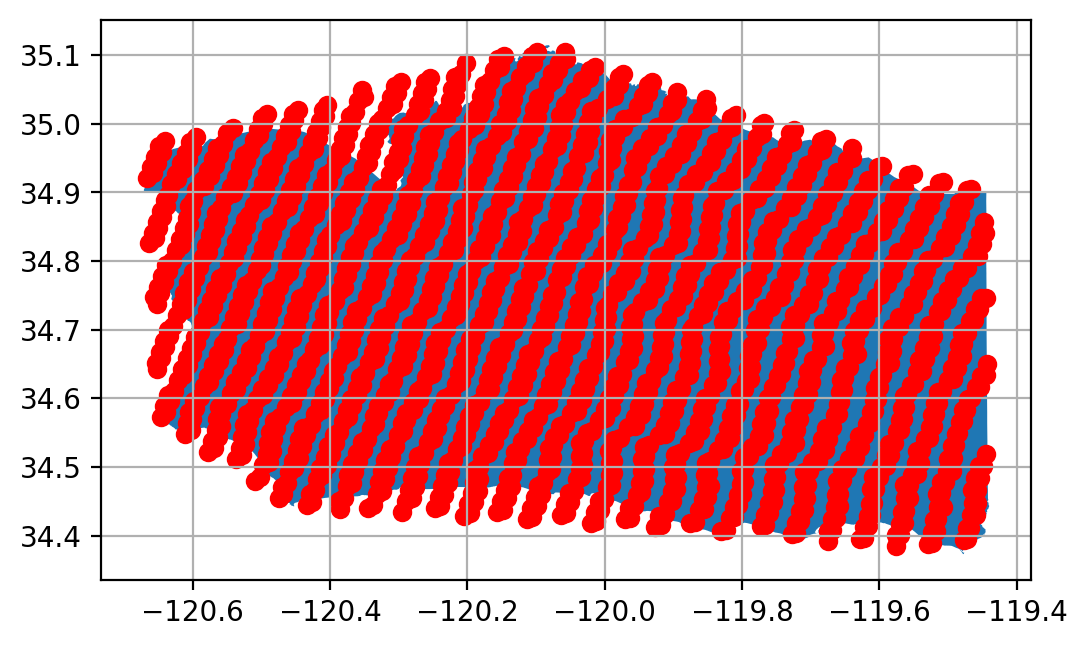

In [18]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax)
convex_points.plot(ax=ax, color='r')

In [5]:
def outbound_intersect(ray, point, gc, lim1, lim2):
    ray_intersect = numpy.cross(gc, ray)
    crosses = (numpy.dot(ray_intersect, lim1)  *  
               numpy.dot(ray_intersect, lim2)) > 0 
    if not crosses:
        return 0
    else: 
        crossing_direction = numpy.dot(point, gc)
        if crossing_direction < 0:
            return 1
        else:
            return -1


ray_dest = numpy.array([0, 0, 1])
def test_point(point):
    ray = numpy.cross(point, ray_dest)
    net_out = 0
    for n in range(len(polygon.convex_edges.gcs)-1):
        net_out += outbound_intersect(ray, 
                                      point, 
                                      polygon.convex_edges.gcs[n], 
                                      polygon.convex_edges.left_gcs[n], 
                                      polygon.convex_edges.right_gcs[n])
    print(net_out)
    if net_out > 0:
        return True
    else:
        return False
    

In [6]:
inside_polygon = []
for point in candidate_points:    
    if test_point(point):
        inside_polygon.append(point)

-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-

In [8]:
len(inside_polygon)

0

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax)

points_convex = []
for j in inside_convex:
    points_convex.append(shapely.geometry.Point(lon[j], lat[j]))
points_convex = geopandas.GeoDataFrame({'geom': points_convex}).set_geometry('geom')
#points_convex.plot(ax=ax, color='red')

points_poly = []
for j in inside_polygon:
    points_poly.append(shapely.geometry.Point(lon[j], lat[j]))
points_poly = geopandas.GeoDataFrame({'geom': points_poly}).set_geometry('geom')
points_poly.plot(ax=ax, color='green')